# Final Project: Modelling Recommendation Systems

- Name: Nicolas Debrito
- email: nicolas.debrito66@gmail.com
- Id Dicoding: reezzy

## Import Library

In [1]:
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer


## Download & Extract Dataset

In [2]:
%pip install kaggle

!kaggle datasets download -d asad11914/myanimelist-novel-rating-dataset

with zipfile.ZipFile('myanimelist-novel-rating-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset')

Dataset URL: https://www.kaggle.com/datasets/asad11914/myanimelist-novel-rating-dataset
License(s): CC0-1.0
 82% 3.00M/3.65M [00:00<00:00, 31.2MB/s]
100% 3.65M/3.65M [00:00<00:00, 34.8MB/s]


# Content-based Filtering

## Data Understanding

In [3]:
novels = pd.read_csv('dataset/novels.csv')
interactions = pd.read_csv('dataset/interactions.csv')

print('Jumlah data novels: ', len(novels.novel_id.unique()))
print('Jumlah data interactions: ', len(interactions))

Jumlah data novels:  4209
Jumlah data interactions:  119295


## Exploratory Data Analysis

In [4]:
novels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   novel_id      4209 non-null   int64  
 1   title         4209 non-null   object 
 2   title_eng     1155 non-null   object 
 3   synopsis      4206 non-null   object 
 4   type          4209 non-null   object 
 5   n_chapters    2226 non-null   float64
 6   authors       4198 non-null   object 
 7   genres        4195 non-null   object 
 8   n_volumes     3183 non-null   float64
 9   status        4209 non-null   object 
 10  score         945 non-null    float64
 11  scored_by     945 non-null    float64
 12  popularty     4209 non-null   int64  
 13  favorites     4209 non-null   int64  
 14  year_start    4208 non-null   float64
 15  year_finnish  1614 non-null   float64
 16  image         4209 non-null   object 
dtypes: float64(6), int64(3), object(8)
memory usage: 559.1+ KB


In [5]:
print('Banyak judul novel: ', len(novels.title.unique()))
print('Banyak genre: ', len(novels.genres.unique()))
print('Genre yang terdaftar: ', novels.genres.unique())

Banyak judul novel:  4207
Banyak genre:  1074
Genre yang terdaftar:  ['Action,Adventure,Fantasy' 'Drama' 'Drama,Romance' ...
 'Action,Fantasy,School,Time Travel'
 'Fantasy,Slice of Life,Iyashikei,Mythology'
 'Comedy,Romance,Harem,Parody,School']


In [6]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119295 entries, 0 to 119294
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  119295 non-null  int64 
 1   username    119295 non-null  object
 2   novel_id    119295 non-null  int64 
 3   interest    119295 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 3.6+ MB


In [7]:
print('Banyak user yang melakukan interaksi: ', len(interactions.username.unique()))
print('Banyak novel yang dirating: ', len(interactions.novel_id.unique()))
print('Banyak interaksi yang bersifat tertarik', len(interactions[interactions['interest'] == 1]))
print('Banyak interaksi yang bersifat tidak tertarik', len(interactions[interactions['interest'] == 0]))

Banyak user yang melakukan interaksi:  36455
Banyak novel yang dirating:  2203
Banyak interaksi yang bersifat tertarik 109925
Banyak interaksi yang bersifat tidak tertarik 9370


In [8]:
novels.head()

,novel_id,title,title_eng,synopsis,type,n_chapters,authors,genres,n_volumes,status,score,scored_by,popularty,favorites,year_start,year_finnish,image
0,143441,Omniscient Reader's Viewpoint,Omniscient Reader's Viewpoint,In the web novel Three Ways to Survive the Apo...,Novel,105.0,sing N song,"Action,Adventure,Fantasy",20.0,Finished,9.03,4673.0,1844,1220,2022.0,2023.0,https://cdn.myanimelist.net/images/manga/1/265...
1,126479,Mikkakan no Koufuku,Three Days of Happiness,Kusunoki used to believe he was destined for g...,Novel,15.0,Miaki Sugaru,Drama,1.0,Finished,8.88,10015.0,578,1295,2013.0,NaN,https://cdn.myanimelist.net/images/manga/3/248...
2,117077,Kimi no Suizou wo Tabetai,I Want to Eat Your Pancreas,A high school boy finds the diary of his class...,Novel,10.0,Sumino Yoru,"Drama,Romance",1.0,Finished,8.65,3415.0,2607,407,2015.0,NaN,https://cdn.myanimelist.net/images/manga/2/248...
3,35513,Koten-bu Series,NaN,Houtarou Oreki is a high school student who li...,Novel,NaN,Yonezawa Honobu,"Adventure,Mystery,School",NaN,Publishing,8.61,3647.0,1013,618,2001.0,NaN,https://cdn.myanimelist.net/images/manga/3/809...
4,6978,Ginga Eiyuu Densetsu,Legend of the Galactic Heroes,"In the far future, two young military leaders ...",Novel,94.0,"Tanaka Yoshiki,Katou Naoyuki,Kamoshita Yukihisa","Action,Adventure,Drama,Sci-Fi,Adult Cast,Milit...",10.0,Finished,8.60,2080.0,1984,310,1982.0,1987.0,https://cdn.myanimelist.net/images/manga/5/155...


In [9]:
interactions.head()

,Unnamed: 0,username,novel_id,interest
0,0,Cli,143441,1
1,1,Guppy000,143441,1
2,2,DarcusGrey,143441,1
3,3,Catboy_Leon,143441,1
4,4,KrappaJn,143441,1


## Data Preprocessing

In [10]:
novels_all = np.concatenate((
    novels.novel_id.unique(),
    interactions.novel_id.unique()
))

novels_all = np.sort(np.unique(novels_all))

print('Jumlah seluruh data movie berdasarkan movieId: ', len(novels_all))

Jumlah seluruh data movie berdasarkan movieId:  4225


In [11]:
novel_interactions = pd.merge(interactions, novels, on='novel_id', how='left')

novel_interactions.head()

,Unnamed: 0,username,novel_id,interest,title,title_eng,synopsis,type,n_chapters,authors,genres,n_volumes,status,score,scored_by,popularty,favorites,year_start,year_finnish,image
0,0,Cli,143441,1,Omniscient Reader's Viewpoint,Omniscient Reader's Viewpoint,In the web novel Three Ways to Survive the Apo...,Novel,105.0,sing N song,"Action,Adventure,Fantasy",20.0,Finished,9.03,4673.0,1844.0,1220.0,2022.0,2023.0,https://cdn.myanimelist.net/images/manga/1/265...
1,1,Guppy000,143441,1,Omniscient Reader's Viewpoint,Omniscient Reader's Viewpoint,In the web novel Three Ways to Survive the Apo...,Novel,105.0,sing N song,"Action,Adventure,Fantasy",20.0,Finished,9.03,4673.0,1844.0,1220.0,2022.0,2023.0,https://cdn.myanimelist.net/images/manga/1/265...
2,2,DarcusGrey,143441,1,Omniscient Reader's Viewpoint,Omniscient Reader's Viewpoint,In the web novel Three Ways to Survive the Apo...,Novel,105.0,sing N song,"Action,Adventure,Fantasy",20.0,Finished,9.03,4673.0,1844.0,1220.0,2022.0,2023.0,https://cdn.myanimelist.net/images/manga/1/265...
3,3,Catboy_Leon,143441,1,Omniscient Reader's Viewpoint,Omniscient Reader's Viewpoint,In the web novel Three Ways to Survive the Apo...,Novel,105.0,sing N song,"Action,Adventure,Fantasy",20.0,Finished,9.03,4673.0,1844.0,1220.0,2022.0,2023.0,https://cdn.myanimelist.net/images/manga/1/265...
4,4,KrappaJn,143441,1,Omniscient Reader's Viewpoint,Omniscient Reader's Viewpoint,In the web novel Three Ways to Survive the Apo...,Novel,105.0,sing N song,"Action,Adventure,Fantasy",20.0,Finished,9.03,4673.0,1844.0,1220.0,2022.0,2023.0,https://cdn.myanimelist.net/images/manga/1/265...


## Data Preparation

In [12]:
novel_interactions_interest = novel_interactions[novel_interactions['interest'] == 1]
novel_interactions_interest = novel_interactions_interest[['username', 'novel_id', 'title', 'genres']]

novel_interactions_interest

,Unnamed: 0,username,novel_id,interest,title,title_eng,synopsis,type,n_chapters,authors,genres,n_volumes,status,score,scored_by,popularty,favorites,year_start,year_finnish,image
0,0,Cli,143441,1,Omniscient Reader's Viewpoint,Omniscient Reader's Viewpoint,In the web novel Three Ways to Survive the Apo...,Novel,105.0,sing N song,"Action,Adventure,Fantasy",20.0,Finished,9.03,4673.0,1844.0,1220.0,2022.0,2023.0,https://cdn.myanimelist.net/images/manga/1/265...
1,1,Guppy000,143441,1,Omniscient Reader's Viewpoint,Omniscient Reader's Viewpoint,In the web novel Three Ways to Survive the Apo...,Novel,105.0,sing N song,"Action,Adventure,Fantasy",20.0,Finished,9.03,4673.0,1844.0,1220.0,2022.0,2023.0,https://cdn.myanimelist.net/images/manga/1/265...
2,2,DarcusGrey,143441,1,Omniscient Reader's Viewpoint,Omniscient Reader's Viewpoint,In the web novel Three Ways to Survive the Apo...,Novel,105.0,sing N song,"Action,Adventure,Fantasy",20.0,Finished,9.03,4673.0,1844.0,1220.0,2022.0,2023.0,https://cdn.myanimelist.net/images/manga/1/265...
3,3,Catboy_Leon,143441,1,Omniscient Reader's Viewpoint,Omniscient Reader's Viewpoint,In the web novel Three Ways to Survive the Apo...,Novel,105.0,sing N song,"Action,Adventure,Fantasy",20.0,Finished,9.03,4673.0,1844.0,1220.0,2022.0,2023.0,https://cdn.myanimelist.net/images/manga/1/265...
4,4,KrappaJn,143441,1,Omniscient Reader's Viewpoint,Omniscient Reader's Viewpoint,In the web novel Three Ways to Survive the Apo...,Novel,105.0,sing N song,"Action,Adventure,Fantasy",20.0,Finished,9.03,4673.0,1844.0,1220.0,2022.0,2023.0,https://cdn.myanimelist.net/images/manga/1/265...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119290,119290,FreakyGeek,156769,1,Nanatsu no Maken ga Shihai suru: Side of Fire ...,Reign of the Seven Spellblades: Side of Fire,"Alvin Godfrey, a failure of a mage, entered Ki...",Light Novel,6.0,"Uno Bokuto,Miyuki Ruria","Action,Fantasy,School",1.0,Finished,NaN,NaN,69420.0,0.0,2023.0,NaN,https://cdn.myanimelist.net/images/manga/3/301...
119291,119291,Puotek,156769,1,Nanatsu no Maken ga Shihai suru: Side of Fire ...,Reign of the Seven Spellblades: Side of Fire,"Alvin Godfrey, a failure of a mage, entered Ki...",Light Novel,6.0,"Uno Bokuto,Miyuki Ruria","Action,Fantasy,School",1.0,Finished,NaN,NaN,69420.0,0.0,2023.0,NaN,https://cdn.myanimelist.net/images/manga/3/301...
119292,119292,rizukurizu,156769,1,Nanatsu no Maken ga Shihai suru: Side of Fire ...,Reign of the Seven Spellblades: Side of Fire,"Alvin Godfrey, a failure of a mage, entered Ki...",Light Novel,6.0,"Uno Bokuto,Miyuki Ruria","Action,Fantasy,School",1.0,Finished,NaN,NaN,69420.0,0.0,2023.0,NaN,https://cdn.myanimelist.net/images/manga/3/301...
119293,119293,Psychomorphosis,156769,1,Nanatsu no Maken ga Shihai suru: Side of Fire ...,Reign of the Seven Spellblades: Side of Fire,"Alvin Godfrey, a failure of a mage, entered Ki...",Light Novel,6.0,"Uno Bokuto,Miyuki Ruria","Action,Fantasy,School",1.0,Finished,NaN,NaN,69420.0,0.0,2023.0,NaN,https://cdn.myanimelist.net/images/manga/3/301...


In [13]:
novel_interactions_interest.isnull().sum()

username       0
novel_id       0
title       1066
genres      1239
dtype: int64

In [14]:
novel_interactions_interest_clean = novel_interactions_interest.dropna()
novel_interactions_interest_clean

,username,novel_id,title,genres
0,Cli,143441,Omniscient Reader's Viewpoint,"Action,Adventure,Fantasy"
1,Guppy000,143441,Omniscient Reader's Viewpoint,"Action,Adventure,Fantasy"
2,DarcusGrey,143441,Omniscient Reader's Viewpoint,"Action,Adventure,Fantasy"
3,Catboy_Leon,143441,Omniscient Reader's Viewpoint,"Action,Adventure,Fantasy"
4,KrappaJn,143441,Omniscient Reader's Viewpoint,"Action,Adventure,Fantasy"
...,...,...,...,...
119290,FreakyGeek,156769,Nanatsu no Maken ga Shihai suru: Side of Fire ...,"Action,Fantasy,School"
119291,Puotek,156769,Nanatsu no Maken ga Shihai suru: Side of Fire ...,"Action,Fantasy,School"
119292,rizukurizu,156769,Nanatsu no Maken ga Shihai suru: Side of Fire ...,"Action,Fantasy,School"
119293,Psychomorphosis,156769,Nanatsu no Maken ga Shihai suru: Side of Fire ...,"Action,Fantasy,School"


In [15]:
novel_interactions_interest_clean.isnull().sum()

username    0
novel_id    0
title       0
genres      0
dtype: int64

In [16]:
fix_novel_interactions = novel_interactions_interest_clean.sort_values('novel_id', ascending=True)
fix_novel_interactions

,username,novel_id,title,genres
35411,Zero_Anime2001,120,Maburaho,"Comedy,Drama,Romance,Harem,School"
35412,Shirahama,120,Maburaho,"Comedy,Drama,Romance,Harem,School"
35413,NSoul13,120,Maburaho,"Comedy,Drama,Romance,Harem,School"
35414,Rokudo69Dokuro,120,Maburaho,"Comedy,Drama,Romance,Harem,School"
35415,Miranjairi,120,Maburaho,"Comedy,Drama,Romance,Harem,School"
...,...,...,...,...
119249,Souryu_Nadia,169340,Shousetsu Sousou no Frieren: Zensou,"Adventure,Drama,Fantasy"
119227,Remy_Jojofag,169340,Shousetsu Sousou no Frieren: Zensou,"Adventure,Drama,Fantasy"
119210,Laelsfilho,169340,Shousetsu Sousou no Frieren: Zensou,"Adventure,Drama,Fantasy"
119184,LoSim,169340,Shousetsu Sousou no Frieren: Zensou,"Adventure,Drama,Fantasy"


In [17]:
print('Jumlah novel bersih: ', len(fix_novel_interactions.novel_id.unique()))
print('Jumlah genre bersih: ', len(fix_novel_interactions.genres.unique()))
print('Genre dari novel yang bersih: ', fix_novel_interactions.genres.unique())

Jumlah novel bersih:  2183
Jumlah genre bersih:  716
Genre dari novel yang bersih:  ['Comedy,Drama,Romance,Harem,School'
 'Comedy,Mystery,Romance,Supernatural,School,Vampire'
 'Drama,Fantasy,Horror,Romance,Sci-Fi,Supernatural'
 'Adventure,Fantasy,Mystery,Sci-Fi,Video Game'
 'Adventure,Drama,Fantasy,Sci-Fi,School,Video Game' 'Drama'
 'Action,Adventure,Fantasy,Horror,Supernatural,Mythology'
 'Comedy,Romance,Ecchi,School'
 'Fantasy,Horror,Mystery,Supernatural,Mythology,Psychological,School'
 'Action,Drama,Fantasy,Romance,Supernatural,Mahou Shoujo,School'
 'Action,Fantasy,Supernatural' 'Comedy,Fantasy,Romance'
 'Adventure,Fantasy,Isekai' 'Action,Adventure,Drama,Fantasy,Military'
 'Action,Drama,Fantasy,Historical,Samurai' 'Drama,Sci-Fi,Mecha'
 'Action,Drama,Sci-Fi,Mecha,Super Power'
 'Action,Drama,Sci-Fi,Mecha,Military,Space'
 'Supernatural,Mythology,Super Power'
 'Action,Adventure,Comedy,Fantasy,Romance,Ecchi,Harem,Isekai,School'
 'Action,Romance,Sci-Fi,Space' 'Drama,Romance' 'Comedy,Roman

In [18]:
preparation = fix_novel_interactions.drop_duplicates('novel_id')
preparation

,username,novel_id,title,genres
35411,Zero_Anime2001,120,Maburaho,"Comedy,Drama,Romance,Harem,School"
25007,mayank_rai,388,Karin Zouketsuki,"Comedy,Mystery,Romance,Supernatural,School,Vam..."
11283,HungerGamesSpain,557,Trinity Blood: Rage Against the Moons,"Drama,Fantasy,Horror,Romance,Sci-Fi,Supernatural"
12379,alekshepard,955,.hack//AI Buster,"Adventure,Fantasy,Mystery,Sci-Fi,Video Game"
14869,DavidSpaghetti,1355,.hack//Another Birth,"Adventure,Drama,Fantasy,Sci-Fi,School,Video Game"
...,...,...,...,...
118868,rAleksandrrr43,165348,"Shousetsu Yokohama Kaidashi Kikou: Mite, Aruki...","Sci-Fi,Slice of Life,Iyashikei"
118991,hadaiarsy,165671,Dare ga Yuusha wo Koroshita ka,"Drama,Fantasy,Mystery"
119068,Kim_Kil_Whan,167040,Moebuta Tensei: Akutoku Shounin dakedo Yuusha ...,"Fantasy,Isekai,Reincarnation"
119099,oniraneo,167572,Gekijouban Haikyuu!!: Gomisuteba no Kessen,"Sports,School,Team Sports"


In [19]:
novel_id = preparation['novel_id'].tolist()

novel_title = preparation['title'].tolist()

novel_genre = preparation['genres'].tolist()

print(len(novel_id))
print(len(novel_title))
print(len(novel_genre))

2183
2183
2183


In [20]:
novel_new = pd.DataFrame({
	'id': novel_id,
	'title': novel_title,
	'genre': novel_genre
})

novel_new

,id,title,genre
0,120,Maburaho,"Comedy,Drama,Romance,Harem,School"
1,388,Karin Zouketsuki,"Comedy,Mystery,Romance,Supernatural,School,Vam..."
2,557,Trinity Blood: Rage Against the Moons,"Drama,Fantasy,Horror,Romance,Sci-Fi,Supernatural"
3,955,.hack//AI Buster,"Adventure,Fantasy,Mystery,Sci-Fi,Video Game"
4,1355,.hack//Another Birth,"Adventure,Drama,Fantasy,Sci-Fi,School,Video Game"
...,...,...,...
2178,165348,"Shousetsu Yokohama Kaidashi Kikou: Mite, Aruki...","Sci-Fi,Slice of Life,Iyashikei"
2179,165671,Dare ga Yuusha wo Koroshita ka,"Drama,Fantasy,Mystery"
2180,167040,Moebuta Tensei: Akutoku Shounin dakedo Yuusha ...,"Fantasy,Isekai,Reincarnation"
2181,167572,Gekijouban Haikyuu!!: Gomisuteba no Kessen,"Sports,School,Team Sports"


## Model Development - Content-based Filtering

In [21]:
df = novel_new
df.sample(5)

,id,title,genre
1426,93628,"Chikai no Kiss made, Ato Nannichi?: Outaishi D...",Romance
488,60559,Aku no Musume,Drama
2066,134108,Meikyuu Kingdom: Tokushubutai SAS no Ossan no ...,"Action,Adventure,Fantasy,Survival"
559,64153,Bootleggers,"Action,Suspense"
1392,92924,Kachikomi Bride!,"Comedy,Romance"


In [22]:
tfVector = TfidfVectorizer()

tfVector.fit(df['genre'])

tfVector.get_feature_names_out()

array(['action', 'adult', 'adventure', 'anthropomorphic', 'arts', 'avant',
       'cast', 'childcare', 'comedy', 'crime', 'crossdressing', 'culture',
       'detective', 'drama', 'ecchi', 'fantasy', 'fi', 'gag', 'game',
       'garde', 'gourmet', 'harem', 'high', 'historical', 'horror',
       'humor', 'idols', 'isekai', 'iyashikei', 'life', 'love', 'magical',
       'mahou', 'male', 'martial', 'mecha', 'medical', 'military',
       'music', 'mystery', 'mythology', 'of', 'organized', 'otaku',
       'parody', 'performing', 'polygon', 'power', 'psychological',
       'reincarnation', 'reverse', 'romance', 'romantic', 'samurai',
       'school', 'sci', 'sex', 'shift', 'shoujo', 'showbiz', 'slice',
       'space', 'sports', 'stakes', 'strategy', 'subtext', 'super',
       'supernatural', 'survival', 'suspense', 'team', 'time', 'travel',
       'vampire', 'video', 'villainess', 'visual', 'workplace'],
      dtype=object)

In [23]:
tfidf_matrix = tfVector.fit_transform(df['genre'])

tfidf_matrix.shape

(2183, 78)

In [24]:
tfidf_matrix.todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.67325002, ..., 0.        , 0.        ,
         0.        ]])

In [25]:
pd.DataFrame(
	tfidf_matrix.todense(),
	columns=tfVector.get_feature_names_out(),
	index=df.title
).sample(22, axis=1).sample(10, axis=0)

,mahou,military,idols,ecchi,magical,love,fi,cast,space,time,...,culture,romance,garde,isekai,strategy,mythology,high,polygon,subtext,slice
title,,,,,,,,,,,,,,,,,,,,,
"Kai, Sasu",0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sabishigariya no Loliferatu,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ori Miko: Kuruwashi no Bikou,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Tensei shite Goushou Musume datta no ni Koukyuuiri desu ka!?,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Anta nanka to Tsukiaeru Wake Nai jan! Muri! Muri! Daisuki!,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.482446,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Shikai Ryuuou to Kyokutou no Avalon,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Returner's Magic Should Be Special,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.638385,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ore no Flag wa Yoridori Mi-dere,0.0,0.0,0.0,0.570261,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.327121,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sengoku Yawoyorozu,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1.        , 0.30769513, 0.24576289, ..., 0.        , 0.0705734 ,
        0.30121418],
       [0.30769513, 1.        , 0.16079737, ..., 0.        , 0.05217243,
        0.        ],
       [0.24576289, 0.16079737, 1.        , ..., 0.06023893, 0.        ,
        0.31861026],
       ...,
       [0.        , 0.        , 0.06023893, ..., 1.        , 0.        ,
        0.10336985],
       [0.0705734 , 0.05217243, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.30121418, 0.        , 0.31861026, ..., 0.10336985, 0.        ,
        1.        ]])

In [27]:
cosine_sim_df = pd.DataFrame(cosine_sim, index=df['title'], columns=df['title'])
print('Shape: ', cosine_sim_df.shape)

cosine_sim_df.sample(10, axis=1).sample(10, axis=0)

Shape:  (2183, 2183)


title,Imouto ga Witch de Komattemasu.,Youkoso Jitsuryoku Shijou Shugi no Kyoushitsu e,Fuusui Shoujo,Ano Hibi wo Mou Ichido,"Houkago no Game Friend, Kimi no Ita Kisetsu",Onmyou Tantei Ranto☆Mashouroku Zero,Shireikan Leon,Kuzu to Kinka no Qualidea,Miko wa Hatsukoi ni Madou: Ou ni Sasageru Yoru no Mitsugi,Musume ja Nakute Mama ga Suki nano!?
title,,,,,,,,,,
Kagurazaka G7: Gakeppuchi Café Kyuushutsu Sakusen Kaigi,0.101283,0.000000,0.169740,0.000000,0.000000,0.000000,0.130358,0.000000,0.000000,0.229821
Material Night,0.183024,0.240772,0.306729,0.374384,0.341775,0.401790,0.000000,0.341775,0.000000,0.000000
Koe de Misete yo Baby,0.148496,0.409671,0.248864,0.303756,0.814193,0.000000,0.191124,0.814193,0.534568,0.336952
Kishi Koi Monogatari,0.277787,0.000000,0.465543,0.568227,0.435241,0.000000,0.357530,0.435241,1.000000,0.630325
Ore no Ibukuro wa Kanojo ni Nigirareteiru.,0.177849,0.000000,0.298057,0.363799,0.000000,0.236587,0.000000,0.000000,0.000000,0.000000
Uchi no Kaichou wa Araburu Toraneko ni Niteiru.,0.504348,0.300513,0.388960,0.000000,0.426577,0.000000,0.649129,0.426577,0.000000,0.526636
Itoshii Wagamama: Furachi na Himistu,0.277787,0.000000,0.465543,0.568227,0.435241,0.000000,0.357530,0.435241,1.000000,0.630325
Daimaou ga Taosenai,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Kuudere Ojousama wa Nanka Chigau: Tatanai Ore to Do S na Kanojo,0.484259,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [28]:
def novel_recommendations(title, similiarity_data=cosine_sim_df, items=df[['title', 'genre']], k=5):
	index = similiarity_data.loc[:, title].to_numpy().argpartition(range(-1, -k, -1))
	colsest = similiarity_data.columns[index[-1: -(k+2): -1]]
	colsest = colsest.drop(title, errors='ignore')

	return pd.DataFrame(colsest).merge(items).head(k)

In [29]:
df[df.title.eq('Shousetsu Sousou no Frieren: Zensou')]

,id,title,genre
2182,169340,Shousetsu Sousou no Frieren: Zensou,"Adventure,Drama,Fantasy"


In [30]:
novel_recommendations('Shousetsu Sousou no Frieren: Zensou')

,title,genre
0,Kingdom Hearts,"Adventure,Drama,Fantasy"
1,Hitotsu no Tairiku no Monogatari: Allison to W...,"Adventure,Drama,Fantasy"
2,Kingdom Hearts: Chain of Memories,"Adventure,Drama,Fantasy"
3,Apocripha/0: Infinite Fortune,"Adventure,Drama,Fantasy"
4,Kyuukyoku Zannen Ougi: Stealth Master,"Adventure,Fantasy"


# Collaborative Filtering

## Data Understanding

In [31]:
interactions

,Unnamed: 0,username,novel_id,interest
0,0,Cli,143441,1
1,1,Guppy000,143441,1
2,2,DarcusGrey,143441,1
3,3,Catboy_Leon,143441,1
4,4,KrappaJn,143441,1
...,...,...,...,...
119290,119290,FreakyGeek,156769,1
119291,119291,Puotek,156769,1
119292,119292,rizukurizu,156769,1
119293,119293,Psychomorphosis,156769,1


## Data Preparation

In [32]:
username = interactions['username'].unique().tolist()
print('list username: ', username)

user_to_user_encoded = {x: i for i, x in enumerate(username)}
print('encoded username: ', user_to_user_encoded)

user_encoded_to_user = {i: x for i, x in enumerate(username)}
print('encoded angka ke username: ', user_encoded_to_user)

list username:  ['Cli', 'Guppy000', 'DarcusGrey', 'Catboy_Leon', 'KrappaJn', 'KrisAnime321', 'ja_kingy', 'Kyoshimm', 'BlurzzBee', 'Esker13', 'Lasicnis', 'RealAuraz', 'Krikru', 'ValerioMaccelli', 'galsgv97', 'Voide', 'Tokyobluesea', 'past_feelings', 'ConjuringScribeZ', 'Endlesspromise', 'dekazen', 'MaouYuno', 'Hardcvstle', 'FFFVeryWholesome', 'Ilyassha', 'cyncitie', 'AneName29', 'griefseeded', 'Donzilla37', 'EAU_', 'HarishaKai', 'tommmmmmmm9', 'pakut2', 'hayhay123', 'txtk', 'ugh_ruby', 'MainakSikder', 'Geraltino', '0ii0i02', 'Spider_vm', 'GuilhermeVasc', 'RegularChezLevi', 'bzzbzzMFbzzbzz', 'hirundiiniv', 'Moonlight_me', 'maxami123', 'CHBanime', '8129a767ec50e223', 'blazing606', 'FangAbi', 'Yamete007', 'NvdBJump', 'Thapple', 'Patientstudent', 'PkKill', 'tuesdaythursday', 'jotaro69joestar', 'Athavan', 'zelindar', 'OtakuNinga', 'helkauron', 'phaedraccentor', 'Lesanwar', 'Mr_Zen4', 'Poosmell', 'xuruxs', 'mateimac123', 'Shirsak_Mitra', 'froppan11', 'Relayn', 'VillanOtaku17', 'goten265', 'Ko

In [33]:
novel_id = interactions['novel_id'].unique().tolist()

novel_to_novel_encoded = {x: i for i, x in enumerate(novel_id)}

novel_encoded_to_novel = {i: x for i, x in enumerate(novel_id)}

In [34]:
interactions['user'] = interactions['username'].map(user_to_user_encoded)

interactions['novel'] = interactions['novel_id'].map(novel_to_novel_encoded)

In [35]:
num_users = len(user_to_user_encoded)
print(num_users)

num_novel = len(novel_to_novel_encoded)
print(num_novel)

interactions['interest'] = interactions['interest'].values.astype(np.float32)

min_interest = min(interactions['interest'])

max_interest = max(interactions['interest'])

print(f'Number of User: {num_users}, Number of Novel: {num_novel}, Min Interest: {min_interest}, Max Interest: {max_interest}')

36455
2203
Number of User: 36455, Number of Resto: 2203, Min Interest: 0.0, Max Interest: 1.0


In [36]:
interactions = interactions.sample(frac=1, random_state=42)
interactions

,Unnamed: 0,username,novel_id,interest,user,novel
74293,74293,testing_works,56813,1.0,1928,1222
69237,69237,LordofBruh1,64119,1.0,19780,1127
51728,51728,AmonSenpai,137599,1.0,22624,772
20980,20980,MrNegativeOne,26613,1.0,12151,289
45895,45895,HunDun,89830,1.0,19730,654
...,...,...,...,...,...,...
76820,76820,Moonlight2390,55383,1.0,19823,1267
110268,110268,mae43,100992,1.0,34996,1921
103694,103694,MarCam12,58335,1.0,6564,1765
860,860,luna-neechan,45885,1.0,768,11


In [37]:
X = interactions[['user', 'novel']].values

y = interactions['interest'].apply(lambda x: (x - min_interest) / (max_interest - min_interest)).values

train_indices = int(0.8 * interactions.shape[0])

X_train, X_val, y_train, y_val = (
    X[:train_indices],
    X[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(X, y)

[[ 1928  1222]
 [19780  1127]
 [22624   772]
 ...
 [ 6564  1765]
 [  768    11]
 [ 8736   220]] [1. 1. 1. ... 1. 1. 1.]


## Model Development - Collaborative Filtering

In [38]:
class RecommenderNet(tf.keras.Model):
    def __init__(self, num_users, num_novel, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_novel = num_novel
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer = 'he_normal',
            embeddings_regularizer = keras.regularizers.l2(1e-6)
		)
        self.user_bias = layers.Embedding(num_users, 1)
        self.resto_embedding = layers.Embedding(
            num_novel,
            embedding_size,
            embeddings_initializer = 'he_normal',
            embeddings_regularizer = keras.regularizers.l2(1e-6)
		)
        self.novel_bias = layers.Embedding(num_novel, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        resto_vector = self.resto_embedding(inputs[:, 1])
        novel_bias = self.novel_bias(inputs[:, 1])

        dot_user_novel = tf.tensordot(user_vector, resto_vector, 2)

        x = dot_user_novel + user_bias + novel_bias

        return tf.nn.sigmoid(x)

In [39]:
model = RecommenderNet(num_users, num_novel, 50)

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer= keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [40]:
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = 8,
    epochs = 30,
    validation_data = (X_val, y_val)
)

Epoch 1/30
11930/11930 [==============================] - 87s 7ms/step - loss: 0.3219 - root_mean_squared_error: 0.3054 - val_loss: 0.2068 - val_root_mean_squared_error: 0.2283
Epoch 2/30
11930/11930 [==============================] - 64s 5ms/step - loss: 0.1764 - root_mean_squared_error: 0.2084 - val_loss: 0.1722 - val_root_mean_squared_error: 0.2047
Epoch 3/30
11930/11930 [==============================] - 62s 5ms/step - loss: 0.1502 - root_mean_squared_error: 0.1917 - val_loss: 0.1615 - val_root_mean_squared_error: 0.1971
Epoch 4/30
11930/11930 [==============================] - 61s 5ms/step - loss: 0.1371 - root_mean_squared_error: 0.1834 - val_loss: 0.1549 - val_root_mean_squared_error: 0.1920
Epoch 5/30
11930/11930 [==============================] - 64s 5ms/step - loss: 0.1269 - root_mean_squared_error: 0.1761 - val_loss: 0.1518 - val_root_mean_squared_error: 0.1896
Epoch 6/30
11930/11930 [==============================] - 66s 6ms/step - loss: 0.1198 - root_mean_squared_error: 0.

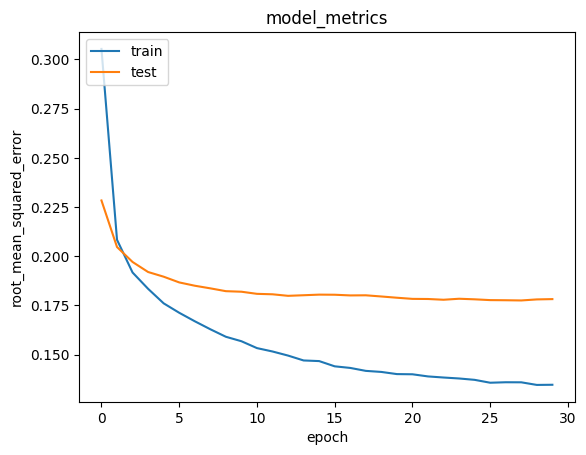

In [41]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [44]:
novel_df = novel_new
df = pd.read_csv('dataset/interactions.csv')

user_id = df.username.sample(1).iloc[0]
novel_interest_by_user = df[df.username == user_id]

unknown_novel = novel_df[~novel_df['id'].isin(novel_interest_by_user.novel_id.values)]['id']
unknown_novel = list(
    set(unknown_novel)
    .intersection(set(novel_to_novel_encoded.keys()))
)

unknown_novel = [[novel_to_novel_encoded.get(x)] for x in unknown_novel]
user_encoder = user_to_user_encoded.get(user_id)
user_novel_array = np.hstack(
    ([[user_encoder]] * len(unknown_novel), unknown_novel)
)

In [45]:
interest = model.predict(user_novel_array).flatten()

top_interest_indices = interest.argsort()[-10:][::-1]
recommended_novel_ids = [
    novel_encoded_to_novel.get(unknown_novel[x][0]) for x in top_interest_indices
]

print(f'Showing recommendations for users: {user_id}')
print('===' * 9)
print('Novel with high interest from user')
print('----' * 8)

top_novel_user = (
    novel_interest_by_user.sort_values(
        by='interest',
        ascending=False
	)
    .head(5)
    .novel_id.values
)

novel_df_rows = novel_df[novel_df['id'].isin(top_novel_user)]
for row in novel_df_rows.itertuples():
    print(row.title, ':', row.genre)

print('----' * 8)
print('Top 10 novel recommendation')
print('----' * 8)

recommended_novel = novel_df[novel_df['id'].isin(recommended_novel_ids)]
for row in recommended_novel.itertuples():
    print(row.title, ':', row.genre)

47/47 [==============================] - 0s 2ms/step
Showing recommendations for users: Tetsuka-B
Novel with high interest from user
--------------------------------
Oute Keika Tori! : School,Strategy Game
Shichinin no Majo to Haikaburi no Sora no Legatus : Action,Fantasy
Reijou Kanteishi to Garou no Akuma : Fantasy,Romance,Mythology
Saikyou no Madoushi. Hiza ni Ya wo Uketeshimatta node Inaka no Eihei ni Naru : Adventure,Fantasy
Furuki Okite no Mahou Kishi : Action,Adventure,Fantasy
--------------------------------
Top 10 novel recommendation
--------------------------------
Golden Time : Comedy,Romance,Love Polygon
Kyoukaisenjou no Horizon : Action,Comedy,Fantasy,Sci-Fi,School
Another : Horror,Mystery,Supernatural,Suspense,School
JoJo's Bizarre Adventure: Over Heaven : Action
Campione! : Action,Fantasy,Supernatural,Harem
Kono Subarashii Sekai ni Shukufuku wo! : Adventure,Comedy,Fantasy,Isekai,Parody
Roman Album: Taishou Dennou Dadaism Emaki - Despera : Sci-Fi,Suspense,Psychological
Qu